# Zipf it up

## Zipf's law: Given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.
### This follows a basic power law (but with additional parameters):
$$ {\displaystyle{\displaystyle p(x)  \propto x^{\alpha}}} $$
### Zipf's law predicts that out of a population of $N$ elements, the normalized frequency of the element of rank $k$, $f(k;\alpha,N)$, is:

$${\displaystyle f(k;\alpha,N)={\frac {1/k^{\alpha}}{\sum \limits _{n=1}^{N}(1/n^{\alpha})}}}$$

#### A dataset can be tested to see whether Zipf's law applies by checking the goodness of fit of the dataset's observed rank frequency distribution to a hypothesized power law distribution by using a Kolmogorov–Smirnov test.



#### This code does all that stuff.

In [1]:
# grepping the installation babbling basically just 
# suppresses the warnings by providing a command that will find them but won't print them.
!pip install powerlaw | grep -v 'Requirement already satisfied' 
import powerlaw
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm, ks_2samp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
data = load_dataset("c4", "en", split= "train", streaming = True)

In [3]:
# For streaming data
data_head = data.take(1000)
df = pd.DataFrame(data_head)
# If not streaming, use:
#df = pd.json_normalize(data)

### Look at the top rows as a sanity-check

In [4]:
df.head()

,timestamp,text,url
0,2019-04-25T12:57:54Z,Beginners BBQ Class Taking Place in Missoula!\...,https://klyq.com/beginners-bbq-class-taking-pl...
1,2019-04-21T10:07:13Z,Discussion in 'Mac OS X Lion (10.7)' started b...,https://forums.macrumors.com/threads/restore-f...
2,2019-04-25T10:40:23Z,Foil plaid lycra and spandex shortall with met...,https://awishcometrue.com/Catalogs/Clearance/T...
3,2019-04-21T12:46:19Z,How many backlinks per day for new site?\nDisc...,https://www.blackhatworld.com/seo/how-many-bac...
4,2019-04-20T14:33:21Z,The Denver Board of Education opened the 2017-...,http://bond.dpsk12.org/category/news/


### Get more basic sanity-check information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  1000 non-null   object
 1   text       1000 non-null   object
 2   url        1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


### Check for missing values

In [6]:
df[df.isnull().any(axis=1)].head()
np.sum(df.isnull().any(axis=1))

0

### Count vocab size + frequencies

In [7]:
def count_vocab_frequencies(df):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    # Move this up as a constant in larger code.
    batch_size = 10
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    # Needed to modify the minimum token length: 
    # https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(df.text)
    document_matrix = cvec.transform(df.text)
    batches = np.linspace(0, df.shape[0], batch_size).astype(int)
    i = 0
    tf = []
    while i < len(batches) - 1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(), axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf, axis=0)], columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns = ['total']
    sorted_term_freq_df = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False)['total'])
    return sorted_term_freq_df

In [8]:
term_df = count_vocab_frequencies(df)
print("Info on the observed frequencies:")
print(term_df.info())
print("Observations look like this:")
print(term_df.head())

Info on the observed frequencies:
<class 'pandas.core.frame.DataFrame'>
Index: 27232 entries, the to 赵维山
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   total   27232 non-null  int64
dtypes: int64(1)
memory usage: 425.5+ KB
None
Observations look like this:
     total
the  19063
to   11027
and  10996
of    8792
a     8496


### Fit the observed totals to a Zipfian powerlaw.
#### Because the ranks are integers, we treat it as a discrete distribution (actually should be 'ordinal' distribution). Our reasoning is that it doesn't make sense to mandate that the distances between the ranks are equal; the values are 'ordinal' actually.
#### We fit this distribution to a power law by minimizing the Kolmogorov–Smirnov (KS) distance.
#### Our reasoning in using a KS objective rather than Maximun Likelihood Estimation (MLE) is that a fundamental assumption of MLE is that individual data points are independent, but that oughtn't be so with the use of words in language (we think)...

In [9]:
import math
# Uses the powerlaw package to fit the observed frequencies to a zipfian distribution

observed_counts = term_df['total'].values
# Turn these into an empirical probability distribution by normalizing by the total sum.
# Note -- doesn't seem to matter actually; can remove.
# norm = float(sum(observed_counts))
# observed_frequencies = observed_counts/norm
# 'fit_method' is MLE by default; doesn't seem to change the results in my initial pokings.
# Also tried discrete_approximation="xmax"
# Note another method for determining alpha 
# might be defined by (Newman, 2005 for details): alpha = 1 + n * sum(ln( xi / xmin )) ^ -1
fit = powerlaw.Fit(observed_counts, fit_method="KS", discrete=True)
# The estimated values
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
distance = fit.power_law.KS()
# We know the optimal xmin, but now let's set the prediction xmin to a lower value
# so we can graph out more beyond the cutoff.
# Note: Bring this up as a parameter that can be set.
fit.xmin = .001
# Reversing the list so x and y both go from high to low
predicted_counts = fit.pdf()[0][::-1]

# The predicted probability distribution
#predicted_frequencies = fit.pdf()[0][::-1]
print("Optimal Alpha:\t\t%.4f" % alpha)
print("Optimal Frequency cut-off:\t%s" % xmin)
print("Distance:\t\t%.4f" % distance)
# Significance testing
# Note: We may want to use bootstrapping (instead of the standard KS test p-value tables) to determine statistical significance
# See: https://stats.stackexchange.com/questions/264431/how-to-determine-if-zipfs-law-can-be-applied Answer #4
print("Checking the goodness of fit of our observed distribution")
print(" to the hypothesized power law distribution")
print(" using a Kolmogorov–Smirnov (KS) test.")
ks_test = ks_2samp(observed_counts, predicted_counts)
# print("KS test:", end='\t\t')
print(ks_test)
print("\nThe KS test p-value is: %.4f" % ks_test.pvalue)
if ks_test.pvalue < .01:
    print("\nYour data fits a powerlaw with a minimum KS distance of %.4f" % distance)
    print("\nWoohoo!")
else:
    print("\nYour data does not fits a powerlaw. =\(")
    print("\nDO BETTER.")

Calculating best minimal value for power law fit
Optimal Alpha:		2.1039
Optimal Frequency cut-off:	33.0
Distance:		0.0212
Checking the goodness of fit of our observed distribution
 to the hypothesized power law distribution
 using a Kolmogorov–Smirnov (KS) test.
KstestResult(statistic=0.38571428571428573, pvalue=6.987725195748793e-10)

The KS test p-value is: 0.0000

Your data fits a powerlaw with a minimum KS distance of 0.0212

Woohoo!


### Graph it out in log-log space to best see the (log) linear difference.

<AxesSubplot:>

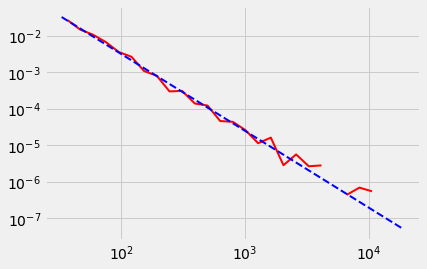

In [10]:
# Graph it out.
fig2 = fit.plot_pdf(color='r', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', linewidth=2, ax=fig2)

In [11]:
def plot_zipf(observed, predicted, alpha=1, multiplier=1):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    """
    num_tokens = len(predicted)
    y_pos = np.arange(num_tokens)
    plt.figure(figsize=(10,10))
    plt.bar(y_pos, observed[:num_tokens]*multiplier, align='center', alpha=0.5)
    plt.plot(y_pos, predicted*multiplier, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top %s words in the dataset, with Zipf's law in dotted red" % num_tokens)

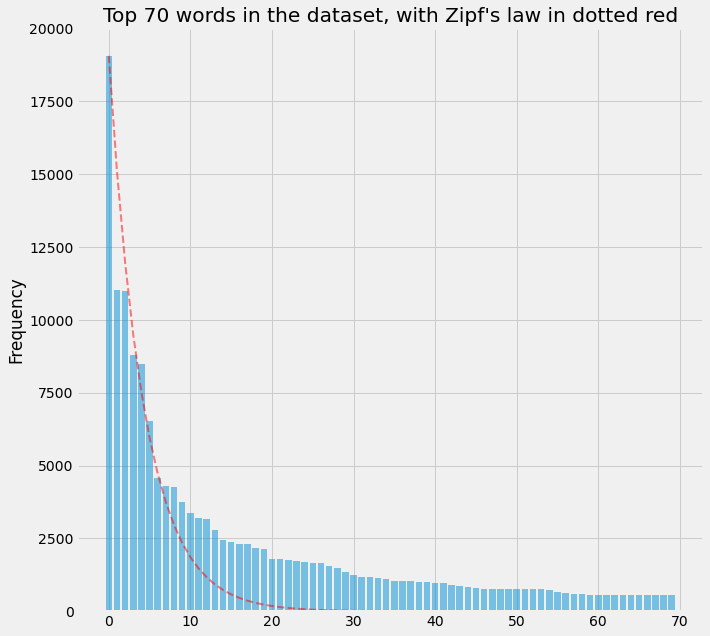

In [12]:
plot_zipf(observed_counts, predicted_counts, alpha=alpha)

#### Check fit to other distributions.
#### This is comparing the log likelihood ratio of the power law distribution to alternative distributions: a truncated power law, an exponential distribution or a lognormal distribution.
#### NB: There's an issue here with handling correlations.
#### I'm not sure this is the best way to do this, esp bc it throws errors.


In [13]:
print("Checking log likelihood ratio to see if the data is better explained")
print("by other well-behaved distributions...")
# The first value returned from distribution_compare is the log likelihood ratio
better_distro = False
trunc = fit.distribution_compare('power_law', 'truncated_power_law')
if trunc[0] < 0:
    print("Seems a truncated power law is a better fit.")
    better_distro = True

lognormal = fit.distribution_compare('power_law', 'lognormal')
if lognormal[0] < 0:
    print("Seems a lognormal distribution is a better fit.")
    print("But don't panic -- that happens sometimes with language.")
    better_distro = True
    
exponential = fit.distribution_compare('power_law', 'exponential')
if exponential[0] < 0:
    print("Seems an exponential distribution is a better fit. Panic.")
    better_distro = True
    
if not better_distro:
    print("\nSeems your data is best fit by a power law. Celebrate!!")

Checking log likelihood ratio to see if the data is better explained
by other well-behaved distributions...


Assuming nested distributions



Seems your data is best fit by a power law. Celebrate!!


/Users/margaretmitchell/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1562: RuntimeWarning: invalid value encountered in log
  norm = 0.5*ss.erfc((np.log(self.xmin)-self.mu) / (np.sqrt(2)*self.sigma))
